<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Mean-Absolute-Errors" data-toc-modified-id="Mean-Absolute-Errors-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Mean Absolute Errors</a></span></li><li><span><a href="#Hyperparameter-Tuning" data-toc-modified-id="Hyperparameter-Tuning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Hyperparameter Tuning</a></span></li><li><span><a href="#3.-GridSearchCV" data-toc-modified-id="3.-GridSearchCV-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>3. GridSearchCV</a></span></li><li><span><a href="#Ensemble-Kernel-Ridge-Regression" data-toc-modified-id="Ensemble-Kernel-Ridge-Regression-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Ensemble Kernel Ridge Regression</a></span></li></ul></div>

# Regression - Assignment 2

Data and Package Import

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pylab as plt

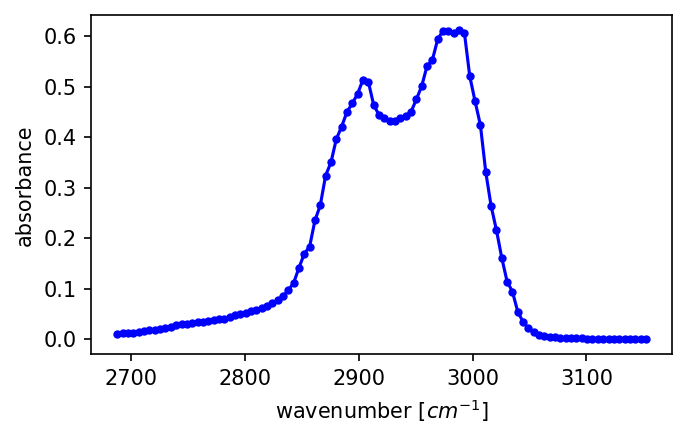

In [2]:
df = pd.read_csv('data/ethanol_IR.csv')
x_all = df['wavenumber [cm^-1]'].values
y_all = df['absorbance'].values

x_peak = x_all[475:575]
y_peak = y_all[475:575]

fig, ax = plt.subplots(figsize = (5, 3), dpi = 150)
ax.plot(x_peak, y_peak, '-b', marker = '.')
ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance');

## Mean Absolute Errors

**Write a function that computes the mean absolute error (MAE).**

In [3]:
def MAE(actual, prediction):
    mae = abs(actual - prediction).mean()
    return mae

**Use 8-fold cross-validation to compute the average and standard deviation of the MAE on the spectra dataset.**

Use a `LinearRegression` model and an `rbf` kernel with $\sigma$=100.

Make sure to pass `shuffle = True` argument when you make a `KFold` object.

In [4]:
def rbf(x_train, x_test = None, gamma = 1):
    if x_test is None:
        x_test = x_train
    N = len(x_test)
    M = len(x_train)
    X = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            X[i, j] = np.exp(-gamma * (x_test[i] - x_train[j])**2)
            
    return X

In [5]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

kfold = KFold(n_splits = 8, shuffle = True)
sigma = 100
gamma = 1. / 2 / sigma**2

listMAE = []

for train_index, test_index in kfold.split(x_peak):
    x_train, x_test = x_peak[train_index], x_peak[test_index]
    y_train, y_test = y_peak[train_index], y_peak[test_index]
    
    X_train = rbf(x_train, gamma = gamma)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    X_test = rbf(x_train, x_test, gamma = gamma)
    
    yhat = model.predict(X_test)
    
    mae = MAE(y_test, yhat)
    listMAE.append(mae)
    
listMAE = np.array(listMAE)
mean = listMAE.mean()
std = listMAE.std()

print('Mean of MAE: {}'.format(mean))
print('Standard deviation of MAE: {}'.format(std))

Mean of MAE: 0.007426851366487635
Standard deviation of MAE: 0.00506196808615005


**Determine the optimum $\sigma$ that results in the lowest mean of MAE based on 8-fold cross validation.**

Vary the width of an `rbf` kernel with $\sigma$ = [1, 10, 50, 100, 150].

In [6]:
sigmas = np.array([1, 10, 50, 100, 150])
gammas = 1. / 2 / sigmas**2

findOptimum = []
for gamma in gammas:
    listMAE = []
    for train_index, test_index in kfold.split(x_peak):
        x_train, x_test = x_peak[train_index], x_peak[test_index]
        y_train, y_test = y_peak[train_index], y_peak[test_index]

        X_train = rbf(x_train, gamma = gamma)

        model = LinearRegression()
        model.fit(X_train, y_train)

        X_test = rbf(x_train, x_test, gamma = gamma)

        yhat = model.predict(X_test)

        mae = MAE(y_test, yhat)
        listMAE.append(mae)
        
    listMAE = np.array(listMAE)
    mean = listMAE.mean()
    findOptimum.append(mean)
    
minIndex = findOptimum.index(min(findOptimum))
optGamma = gammas[minIndex]
optSigma = sigmas[minIndex]

print(findOptimum)

print('Optimal gamma: {}'.format(optGamma))
print('Optimal sigma: {}'.format(optSigma))

[0.20038408530712962, 0.5784814793872782, 0.015588800599666802, 0.008753082948173892, 0.016254492921130473]
Optimal gamma: 5e-05
Optimal sigma: 100


## Hyperparameter Tuning

**Reshape `x_peak` and `y_peak` into 2D arrayx.**

In [7]:
x_peak = x_peak.reshape(-1, 1)
y_peak = y_peak.reshape(-1, 1)

**Do a train/test split with `test_size=0.3` for the spectra data.**

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_peak, y_peak, test_size = 0.3)

**Use a `for` loop to determine the optimum regularization strength $\alpha$ of a KRR model.**

Use an `rbf` kernel with $\sigma$=20.

Determine the optimum value of $\alpha$ out of [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1].

In [9]:
from sklearn.kernel_ridge import KernelRidge

alphas = np.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])

sigma = 20
gamma = 1. / 2 / sigma**2

listR2 = []
for alpha in alphas:
    KRR = KernelRidge(alpha = alpha, kernel = 'rbf', gamma = gamma)
    KRR.fit(x_train, y_train)
    
    yhat = KRR.predict(x_test)
    r2 = KRR.score(x_test, y_test)
    listR2.append(r2)
    
maxIndex = listR2.index(max(listR2))
optAlpha = alphas[maxIndex]

print(listR2)
print('Optimal alpha: {}'.format(optAlpha))

[0.9984200372983285, 0.9984430064066064, 0.9983755583531992, 0.998370537316032, 0.9981447116555068, 0.9699372172069529]
Optimal alpha: 0.0001


## 3. GridSearchCV

**Import a LASSO model.**

In [10]:
from sklearn.linear_model import Lasso

**Shuffle the `x_peak` and `y_peak`.**

You can get a shuffled array when you run `x_shuffle, y_shuffle = shuffle(x, y)`.

The reason why we shuffle the data is that `GridSearchCV` does not have an option to shuffle the input data. Note that we automatically shuffled the data using the `shuffle=True` argument in the `Kfold` function.

In [11]:
from sklearn.utils import shuffle

x_peak_shuffle, y_peak_shuffle = shuffle(x_peak, y_peak)

**Build a `GridSearchCV` model that optimizes the hyperparameters of a LASSO model for the spectra data.**

Search over $\alpha \in$ [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1] and $\sigma \in$ [5, 10, 15, 20, 25, 30, 35, 40].

Use 3-fold cross-validation.

*Hint: You will need to use a `for` loop over $\sigma$ values. Unlike KRR, LASSO models do not take `gamma` or `sigma` as a parameter. Therefore, you have to make an `rbf` kernel manually and input it to a LASSO model.*

Obtain the optimum $\alpha$ and the best score for each $\sigma$ value. Use `GridSearchCV.best_score_` as an accuracy metric.

In [12]:
#Let's ignore the warnings
import warnings
warnings.simplefilter('ignore')

In [13]:
# not valid but acceptable answer
from sklearn.model_selection import GridSearchCV

alphas = np.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
sigmas = np.array([5, 10, 15, 20, 25, 30, 35, 40])

listEstimator = []
listScore = []
for sigma in sigmas:
    gamma = 1. / 2 / sigma**2
    
    x_train, x_test, y_train, y_test = train_test_split(x_peak_shuffle, y_peak_shuffle, test_size = 0.3)
    
    X_train = rbf(x_train, gamma = gamma)
    X_test = rbf(x_train, x_test, gamma = gamma)
    
    lasso = Lasso()
    param_grid = {'alpha': alphas}
    lasso_search = GridSearchCV(lasso, param_grid, cv = 3)
    lasso_search.fit(X_train, y_train)
    
    listEstimator.append(lasso_search.best_estimator_)
    
    score = lasso_search.best_estimator_.score(X_test, y_test)
    listScore.append(score)
    
maxIndex = listScore.index(max(listScore))
optAlpha = listEstimator[maxIndex].alpha
optSigma = sigmas[maxIndex]

print('Optimal alpha: {}'.format(optAlpha))
print('Optimal sigma: {}'.format(optSigma))

Optimal alpha: 0.0001
Optimal sigma: 30


In [14]:
# Using 2 for loops
alphas = np.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
sigmas = np.array([5, 10, 15, 20, 25, 30, 35, 40])

x_train, x_test, y_train, y_test = train_test_split(x_peak, y_peak, test_size = .3)

findAlpha =[]
for alpha in alphas:
    findSigma = []
    for sigma in sigmas:
        gamma = 1. / 2 / sigma**2
        
        X_train = rbf(x_train, gamma = gamma)
        X_test = rbf(x_train, x_test, gamma = gamma)
        
        lasso = Lasso(alpha = alpha)
        
        lasso.fit(X_train, y_train)
        r2 = lasso.score(X_test, y_test)
        
        findSigma.append(r2)
    optSigmaIndex = findSigma.index(max(findSigma))
    suboptSigma = sigmas[optSigmaIndex]
    submaxR2 = max(findSigma)
    
    findAlpha.append((submaxR2, suboptSigma))
    
optAlphaIndex = findAlpha.index(max(findAlpha))
optAlpha = alphas[optAlphaIndex]
optSigma = findAlpha[optAlphaIndex][1]
maxR2 = findAlpha[optAlphaIndex][0]

print(findAlpha)

[(0.9984186501247988, 15), (0.9984826818030107, 30), (0.9968090612710975, 30), (0.9296158632378431, 30), (-0.011856591089540292, 5), (-0.011856591089540292, 5)]


In [15]:
# Working on using pipeline...

**What is the optimum $\sigma$ and $\alpha$?**

In [16]:
print('Optimal alpha: {}'.format(optAlpha))
print('Optimal sigma: {}'.format(optSigma))

Optimal alpha: 0.0001
Optimal sigma: 30


**Optional Task**

**Check what happens if the input data is not shuffled before the `GridSearchCV`.**

## Ensemble Kernel Ridge Regression

In this problem you will combine ideas from k-fold cross-validation and bootstrapping with KRR to create an **ensemble** of KRR models.

**Reshape `x_peak` and `y_peak` into 2D array.**

In [17]:
x_peak = x_peak.reshape(-1, 1)
y_peak = y_peak.reshape(-1, 1)

**Use 5-fold cross-validation with the spectra data to construct a series of 5 KRR models with a `rbf` kernel with $\gamma$=0.0005 and $\alpha$=0.01.**

Each model will be trained with 80% of the data, but the exact training points will vary each time so the models will also vary.

You can use all of the data points in the `x_peak` for generating the predictions (in other words, predict on both the training and testing data).

In [18]:
kfold = KFold(n_splits = 5, shuffle = True)

yhatList = []

for train_index, test_index in kfold.split(x_peak):
    x_train, x_test = x_peak[train_index], x_peak[test_index]
    y_train, y_test = y_peak[train_index], y_peak[test_index]
    
    KRR = KernelRidge(gamma = 0.0005, kernel = 'rbf', alpha = 0.01)
    KRR.fit(x_train, y_train)
    
    yhat = KRR.predict(x_peak)
    
    yhatList.append(yhat.reshape(-1,))

**Plot the resulting ensemble of models along with the original data.**

The plot should consists of 6 different lines (1 from the original data and 5 from each of the slightly different KRR models).

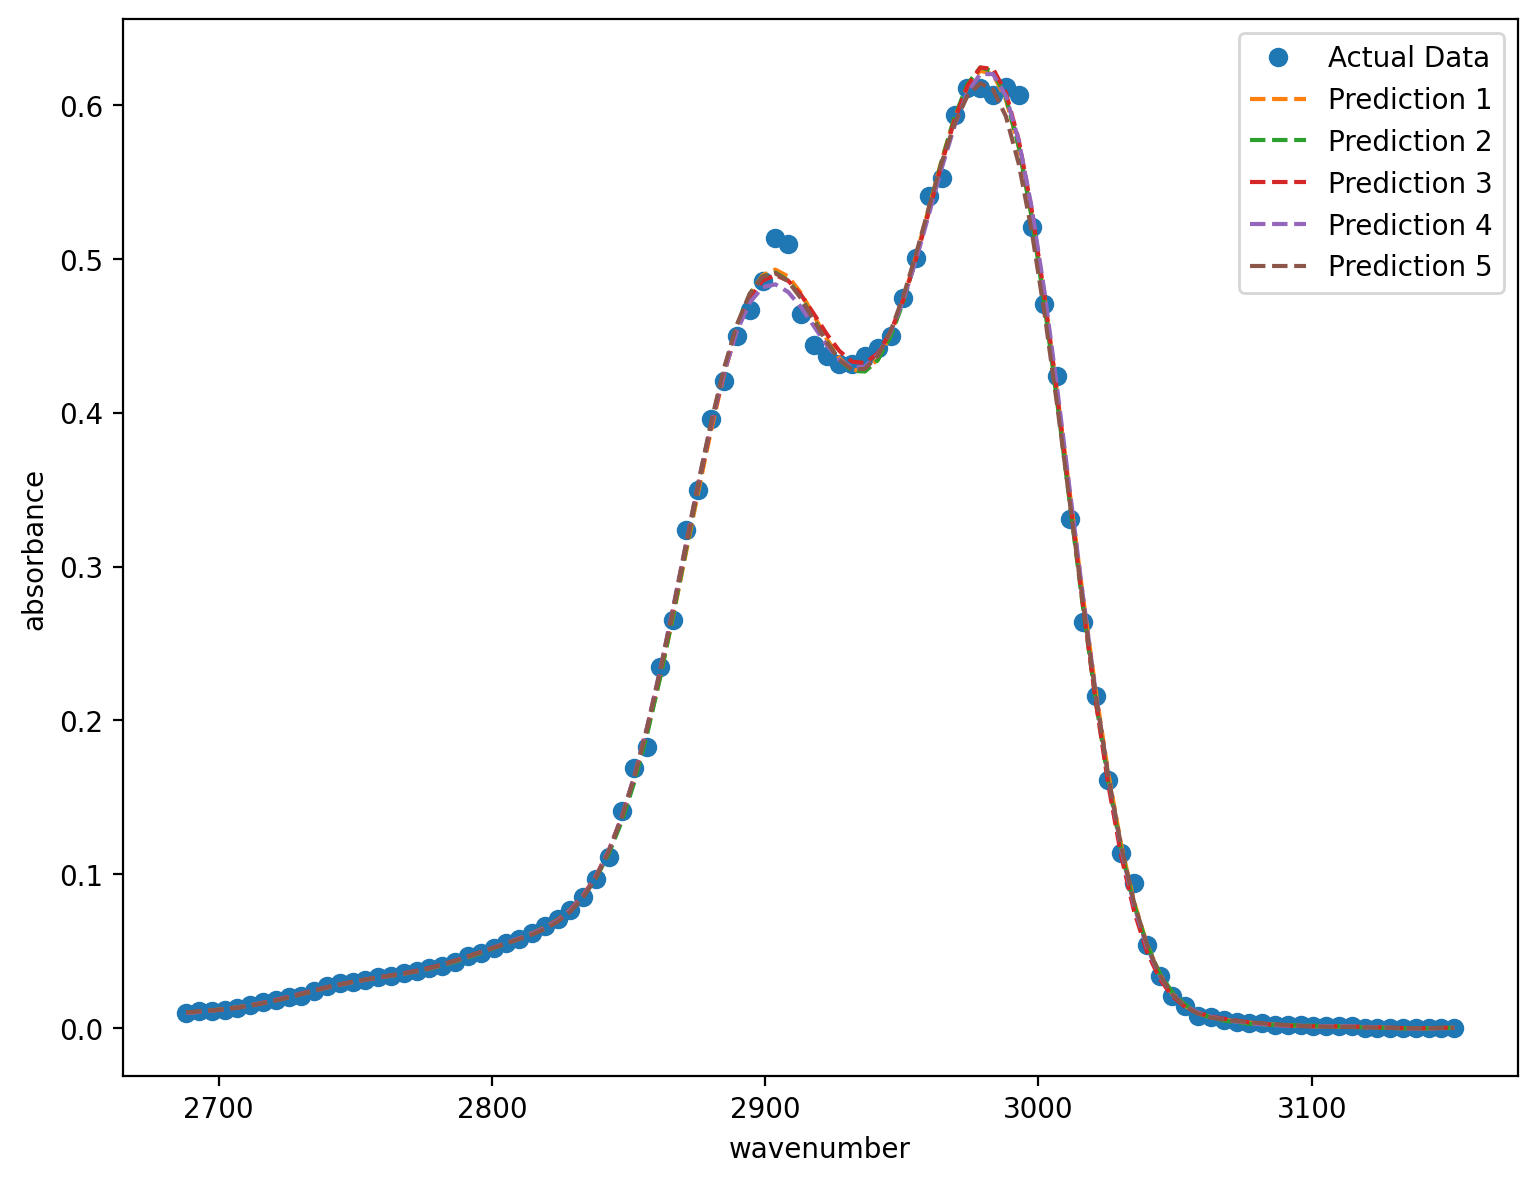

In [19]:
fig, ax = plt.subplots(figsize = (9, 7), dpi = 200)

ax.plot(x_peak, y_peak, 'o', label = 'Actual Data')
for i in range(5):
    ax.plot(x_peak, yhatList[i], '--', label = 'Prediction {}'.format(i + 1))
ax.set_xlabel('wavenumber')
ax.set_ylabel('absorbance')
ax.legend()
plt.show()

**Plot the standard deviation of the 5 KRR model predictions as a function of wavenumber.**

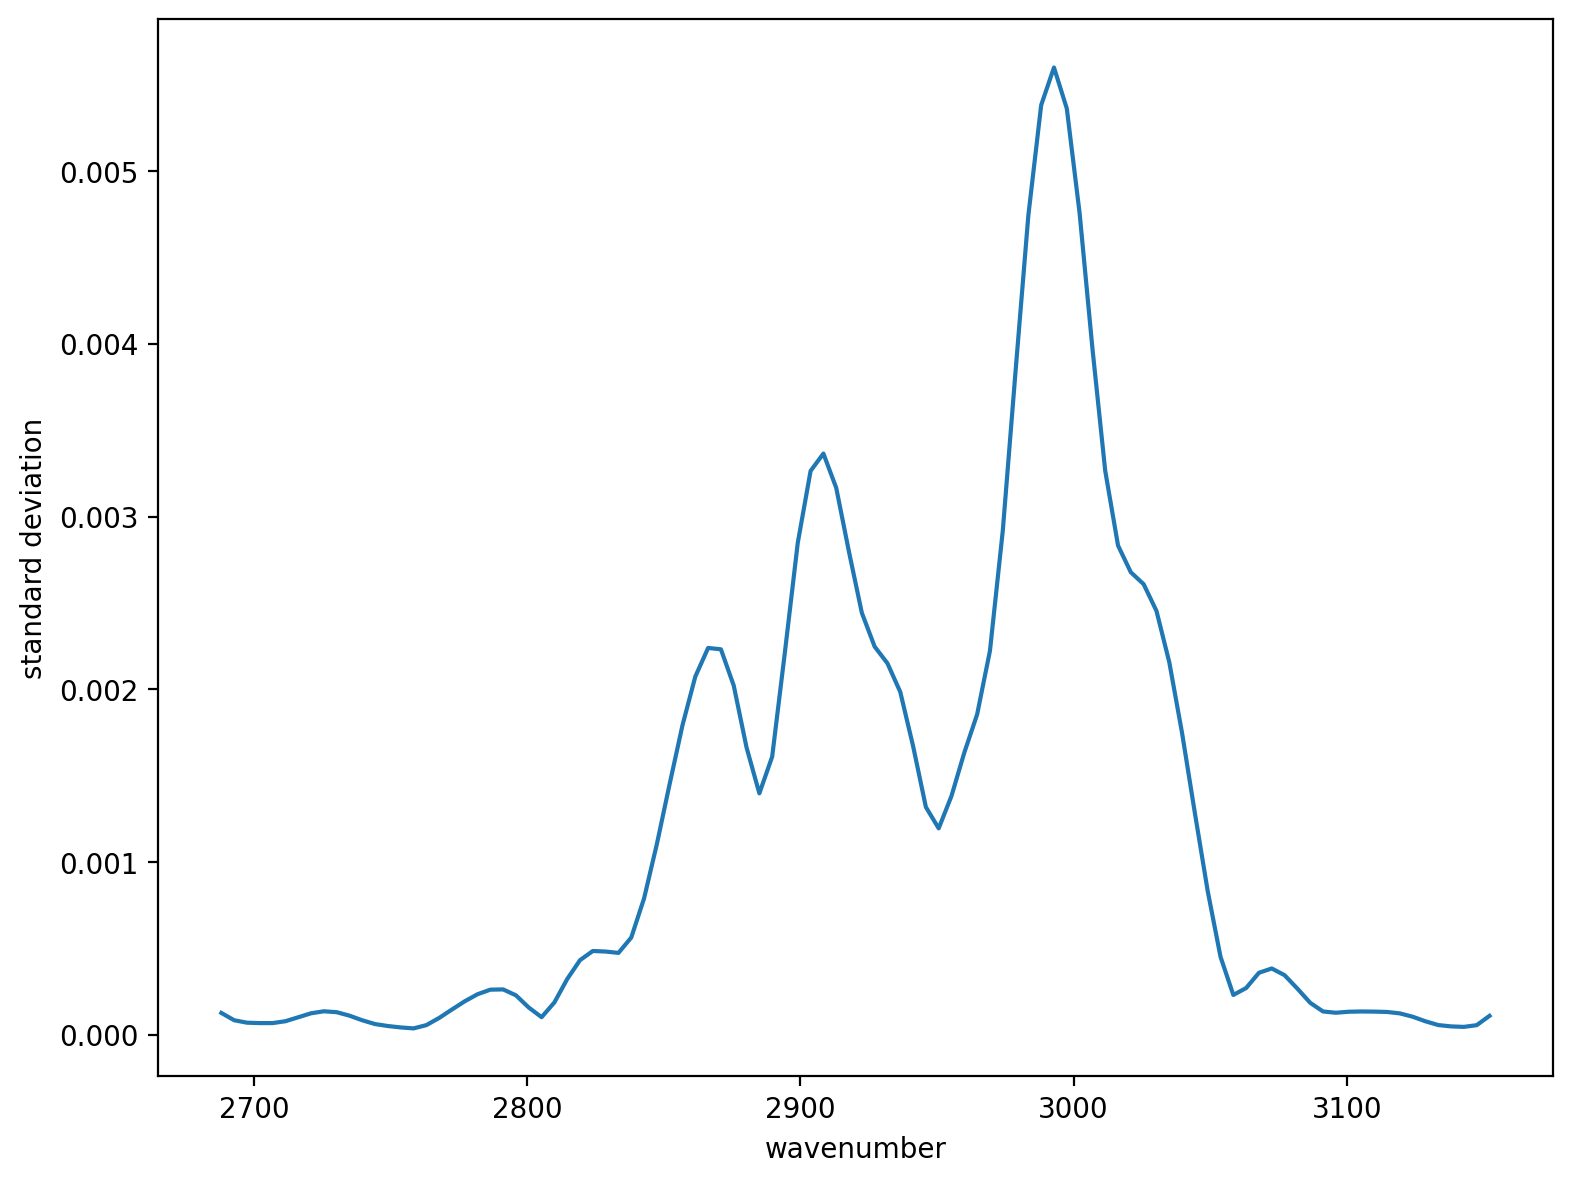

In [20]:
yhatList = np.array(yhatList)
std = yhatList.std(axis = 0)

fig, ax = plt.subplots(figsize = (9, 7), dpi = 200)
ax.plot(x_peak, std)
ax.set_xlabel('wavenumber')
ax.set_ylabel('standard deviation')
plt.show()

**Is the predicted error homoscedastic? Briefly explain.**

No, it's not.